# OpenSCM Timeseries

*Note:* These notebooks will be re-written as part of our [first milestone](https://github.com/openclimatedata/openscm/milestone/1)

*Suggestions for update:* tighten up language including defining the concepts of 'point' and 'average' more clearly, step through conversions more slowly with more plots, add assertions to prove that openscm output is same as process we're describing in this notebook, annotate the average conversion plot to explain what is going on

In OpenSCM, the class for handling timeseries conversion is `openscm.timeseries_converter.TimeseriesConverter`.

Like in everyday usage, a timeseries in OpenSCM is a series of data points associated with specific points in time i.e. discrete data. We call the values used to initialise the timeseries the 'source data' and the times with which they are associated the 'source times'.

To estimate the value of the variable under consideration at points in time other than the source points (call these points the 'target times'), i.e. to interpolate or extrapolate, we always take the following steps:

1. start with the data which was originally used to set the timeseries
1. convert the discrete data to continuous data using an interpolation/extrapolation technique
    - e.g. linear interpolation, cubic spline, moving average
1. use the continuous data to determine the values at the target times aka the 'target values'

There is one additional complication in this process. It is the different conventions that are used with timeseries. For example, sometimes the data value is the value only at the exact point in time for which it is supplied while other times the data value represents the average of the underlying continuous data set over a given time period. These conventions affect how the conversion between continuous and discrete data is done and hence are vital to document and understand.

*Note:* In order to recover the original data from the target data, you need to know which assumptions have been made in the interpolation process and what convention is being used.

In this notebook we go through the different interpolation and extrapolation options available to OpenSCM users as well as the different conventions OpenSCM understands. If your particular use case is not here, please raise an issue at [https://github.com/openclimatedata/openscm/issues]().

In [1]:
from itertools import count
from copy import copy
import re
import traceback

import numpy as np
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from matplotlib import pyplot as plt

from openscm.errors import InsufficientDataError
from openscm.core.parameterset import ParameterSet
from openscm.core.parameters import ParameterType
from openscm.core.time import (
    _calc_interval_averages,
    create_time_points,
    InterpolationType,
    ExtrapolationType,
    TimeseriesConverter,
)

In [2]:
def datetime64_linspace(fr, to, num):
    return np.linspace(
        fr.astype("datetime64[s]").astype(float),
        to.astype("datetime64[s]").astype(float),
        num,
        dtype="datetime64[s]"
    )

In [3]:
COLOUR_1 = "lime"
COLOUR_2 = "midnightblue"
COLOUR_3 = "firebrick"
COLOUR_4 = "deeppink"

MARKER_1 = "o"
MARKER_2 = "^"
MARKER_3 = "+"
MARKER_4 = "x"

## Holding data

In OpenSCM, all data is stored in instances of `ParameterSet`. 

In [4]:
paras = ParameterSet()

---
## Example 1: Point data without extrapolation

The simplest and most familiar case is handling point data i.e. data which represents the value of a quantity at an exact point in time. In future we intend to add a cubic interpolation option but it is not yet available.

### Source data

To start with, we set our source data. This always involves specifying the time axis and the data values. 

In [5]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_times = np.datetime64("2000-01-01") + np.array([0, 10, 15, 20, 23, 28, 30, 50]).astype("timedelta64[D]")
point_view = paras.timeseries(
    ("Emissions", "CH4"),
    "MtCH4 / yr",
    source_times,
    timeseries_type=ParameterType.POINT_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.NONE,
)
point_view.values = source_values

/home/sven/sync/openclimatedata/openscm/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


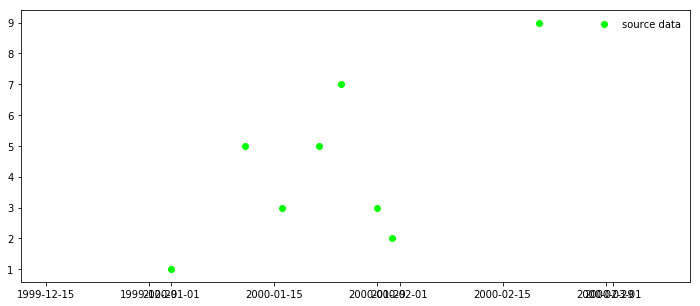

In [6]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

### Target data

Next we set our target, using one of OpenSCM's `ParameterView`'s.

In [7]:
target_times = np.datetime64("2000-01-01") + np.array([5, 10, 20, 30, 40, 45, 50]).astype("timedelta64[D]")
point_target_view = paras.timeseries(
    ("Emissions", "CH4"),
    "MtCH4 / yr",
    target_times,
    timeseries_type=ParameterType.POINT_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.NONE,
)

### Conversion

To convert from discrete to continuous data, we interpolate the data to a continuous function using scipy's interpolate module. In a second step, we calculate the target values by determining the value of the interpolated function at the target times. We compare the output of OpenSCM and our minimal working example in the cell below. Our minimal working example simply shows how OpenSCM works under the hood without all of the extra wrapping and type checking which OpenSCM performs.

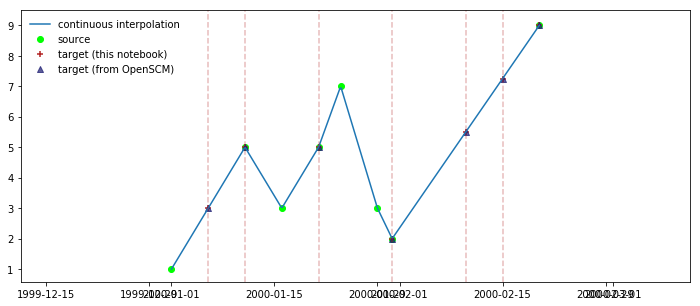

In [8]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source",
)
fine_times = datetime64_linspace(
    source_times[0],
    source_times[-1],
    300,
)
interp = interpolate.interp1d(
    source_times.astype("datetime64[s]").astype(float),
    source_values,
)
ax.plot(
    fine_times,
    interp(fine_times.astype("datetime64[s]").astype(float)),
    label="continuous interpolation",
)
ax.scatter(
    target_times,
    interp(target_times.astype("datetime64[s]").astype(float)),
    color=COLOUR_3,
    marker=MARKER_3,
    label="target (this notebook)",
)
ax.scatter(
    target_times,
    point_target_view.values,
    marker=MARKER_2,
    color=COLOUR_2,
    alpha=0.7,
    label="target (from OpenSCM)",
)
for x in target_times[:-1]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend(frameon=False);

---
## Example 2: Point data with extrapolation

It is possible to automatically extrapolate the data using OpenSCM.

### Source data

In [9]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_times = np.datetime64("2000-01-01") + np.array([0, 10, 15, 20, 23, 28, 30, 50]).astype("timedelta64[D]")
point_view = paras.timeseries(
    ("Emissions", "CH4"),
    "MtCH4 / yr",
    source_times,
    timeseries_type=ParameterType.POINT_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.LINEAR,
)
point_view.values = source_values

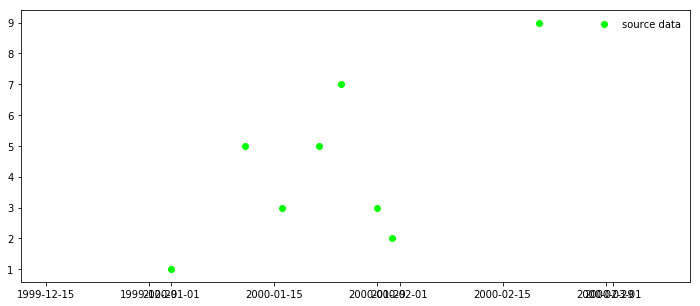

In [10]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

### Target data and conversion

Using different extrapolation types, we can get different results. This process is sufficiently trivial that we can illustrate how it works for a variety of cases (and compare to OpenSCM output) in the cell below.

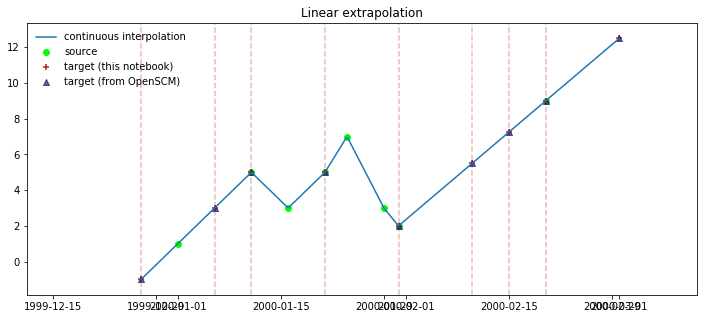

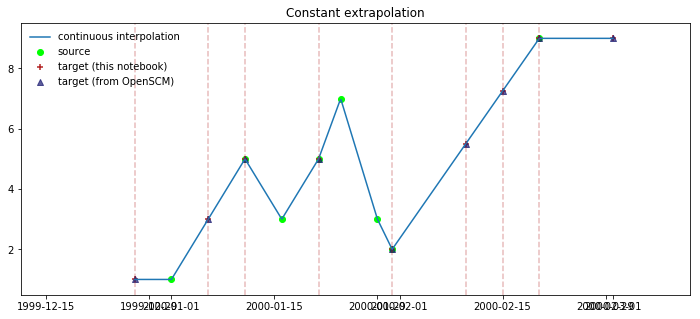

In [11]:
target_times = np.datetime64("2000-01-01") + np.array([-5, 5, 10, 20, 30, 40, 45, 50, 60]).astype("timedelta64[D]")
examples = [
    (
        "Linear extrapolation", 
        ExtrapolationType.LINEAR, 
        {"fill_value": "extrapolate"}
    ),
    (
        "Constant extrapolation", 
        ExtrapolationType.CONSTANT, 
        {"fill_value": (source_values[0], source_values[-1]), "bounds_error": False}
    ),
]
for (title, extrap_type, numpy_kwargs) in examples:
    point_target_view = paras.timeseries(
        ("Emissions", "CH4"),
        "MtCH4 / yr",
        target_times,
        timeseries_type=ParameterType.POINT_TIMESERIES,
        interpolation=InterpolationType.LINEAR,
        extrapolation=extrap_type,
    )

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.scatter(
        source_times,
        source_values,
        marker=MARKER_1,
        color=COLOUR_1,
        label="source",
    )
    fine_times = datetime64_linspace(
        target_times[0],
        target_times[-1],
        300,
    )
    interp = interpolate.interp1d(
        source_times.astype("datetime64[s]").astype(float),
        source_values,
        **numpy_kwargs
    )
    ax.plot(
        fine_times,
        interp(fine_times.astype("datetime64[s]").astype(float)),
        label="continuous interpolation",
    )
    ax.scatter(
        target_times,
        interp(target_times.astype("datetime64[s]").astype(float)),
        color=COLOUR_3,
        marker=MARKER_3,
        label="target (this notebook)",
    )
    ax.scatter(
        target_times,
        point_target_view.values,
        marker=MARKER_2,
        color=COLOUR_2,
        alpha=0.7,
        label="target (from OpenSCM)",
    )
    ax.legend(frameon=False)
    for x in target_times[:-1]:
        ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
    ax.set_title(title);

If you try to extrapolate with the extrapolation type set to `ExtrapolationType.NONE` then you will receive an `InsufficientDataError`.

In [12]:
target_times = np.datetime64("2000-01-01") + np.array([5, 10, 20, 30, 40, 45, 50, 60]).astype("timedelta64[D]")
temp_view = paras.timeseries(
    ("Emissions", "CH4"),
    "MtCH4 / yr",
    target_times,
    timeseries_type=ParameterType.POINT_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.NONE,
)
try:
    temp_view.values
except InsufficientDataError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
openscm.errors.InsufficientDataError: Target time points are outside the source time points, use an extrapolation type other than None


---
## Example 3: Period average data with linear interpolation

The most complex case OpenSCM can handle is linear interpolation of data where the convention is that the source values represent the average of the underlying timeseries over a time period. This time period extends from the time time at which the value is provided, the 'data time', up until the next time in the timeseries. A common example for such a convention is emissions data, where each time point represents the average emissions flux for that time period e.g. 2100 emissions of 3 GtC / yr means that the average rate of emissions for 2100 was 3 GtC / yr.

<div class="alert alert-warning">
  <strong>Warning!</strong> Emissions data is ocassionally reported without the rate e.g. 2100 emissions were 3 GtC. Before passing emissions data into OpenSCM it should have the units converted to rates (of course, cumulative emissions data should not be reported as rates and so perhaps the only fix required is changing the variable name from `Emissions` to `Cumulative Emissions`).
</div>

### Source data

In [13]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_period_length = np.timedelta64(10, "D")
source_times = create_time_points(
    start_time=np.datetime64("2000-01-01"),
    period_length=source_period_length,
    points_num=len(source_values),
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
)
source_view = paras.timeseries(
    ("Emissions", "CO2"),
    "GtC / yr",
    source_times,
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.LINEAR,
)
source_view.values = source_values

Here we use `create_time_points` to generate a set of even length time periods. As we're considering 'average timeseries', `create_time_points` recognises that 'average timeseries' need to specify the start and end point of each timestep and so adds an extra time point at the end of our source times to ensure that they are properly bounded.

In [14]:
create_time_points(
    start_time=np.datetime64("2000-01-01"),
    period_length=source_period_length,
    points_num=len(source_values),
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
)

array(['2000-01-01T00:00:00', '2000-01-11T00:00:00',
       '2000-01-21T00:00:00', '2000-01-31T00:00:00',
       '2000-02-10T00:00:00', '2000-02-20T00:00:00',
       '2000-03-01T00:00:00', '2000-03-11T00:00:00',
       '2000-03-21T00:00:00'], dtype='datetime64[s]')

In [15]:
# this doesn't have the bounding final point as
# it's for point timeseries
create_time_points(
    start_time=np.datetime64("2000-01-01"),
    period_length=source_period_length,
    points_num=len(source_values),
    timeseries_type=ParameterType.POINT_TIMESERIES,
)

array(['2000-01-01T00:00:00', '2000-01-11T00:00:00',
       '2000-01-21T00:00:00', '2000-01-31T00:00:00',
       '2000-02-10T00:00:00', '2000-02-20T00:00:00',
       '2000-03-01T00:00:00', '2000-03-11T00:00:00'],
      dtype='datetime64[s]')

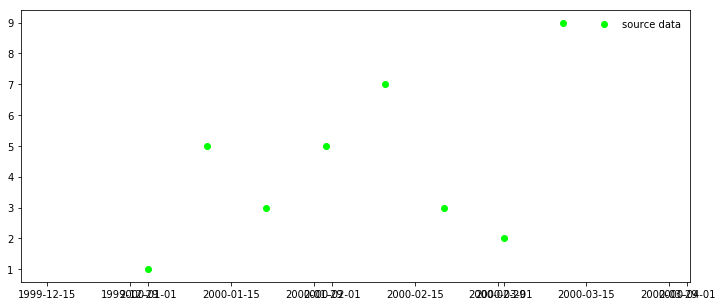

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times[:-1],
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

### Target data

In [17]:
target_period_length = np.timedelta64(7, "D")
target_times = create_time_points(
    start_time=np.datetime64("2000-01-01") - np.timedelta64(3, "D"),
    period_length=target_period_length,
    points_num=int(len(source_values) * 10.0 / 7.0) + 1,
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
)
target_view = paras.timeseries(
    ("Emissions", "CO2"),
    "GtC / yr",
    target_times,
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
    interpolation=InterpolationType.LINEAR,
    extrapolation=ExtrapolationType.LINEAR,
)

### Conversion

To convert from discrete to continuous data, we interpolate the data such that their average (i.e. integral over the period divided by the period length) equals the original source data. We use three points per period: at each period edge the value is assumed to equal the average of the values for the two adjacent periods and at the period mid point the value is adjusted such that the period average equals the source data value for that period. For the first and the last period the mid points are assumed to be at the period average and the outer edges are adjusted accordingly.

The plot below illustrates this. To make it easier to see how the interpolation is integral preserving, we plot the source data with lines which show the integral, following the assumption that the data values represent the average over the time period.

In [18]:
def plot_timeframe(ax, times, values, **kwargs):
    ax.step(times, np.concatenate(([values[0]], values)), **kwargs)

In [19]:
converter = TimeseriesConverter(
    source_times,
    target_times,
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
    interpolation_type=InterpolationType.LINEAR,
    extrapolation_type=ExtrapolationType.LINEAR,
)

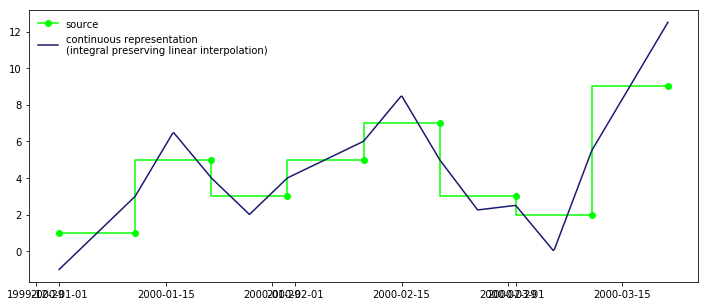

In [20]:
continuous = converter._calc_continuous_representation(
    source_times.astype(float),
    source_values.astype(float),
)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
plot_timeframe(
    ax, 
    source_times,
    source_values,
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    source_times[0].astype(float),
    source_times[-1].astype(float),
    500,
    dtype="datetime64[s]",
)
ax.plot(
    plt_times, 
    continuous(plt_times), 
    label="continuous representation\n(integral preserving linear interpolation)",
    marker=None,
    color=COLOUR_2,
)
ax.legend(frameon=False);

In a second step, we calculate the target values by determining all the interval averages (calculated by integrating the continuous function and then dividing by the time period length).

In [21]:
interval_times = target_times
interval_averages = _calc_interval_averages(
    continuous,
    interval_times.astype(int)
)

In [22]:
interval_averages

array([-0.8       ,  2.02142857,  5.37857143,  3.42857143,  3.34285714,
        5.1       ,  7.18571429,  5.44642857,  2.49642857,  1.20714286,
        5.59285714, 10.75      ])

Under the hood, OpenSCM does the integration in the following way:

In [23]:
integrals = [np.nan] * len(interval_times[:-1])
for i, l in enumerate(interval_times.astype(int)[:-1]):
    u = interval_times.astype(int)[i + 1]
    y, _ = integrate.quad(continuous, l, u)
    integrals[i] = y

#### Plot

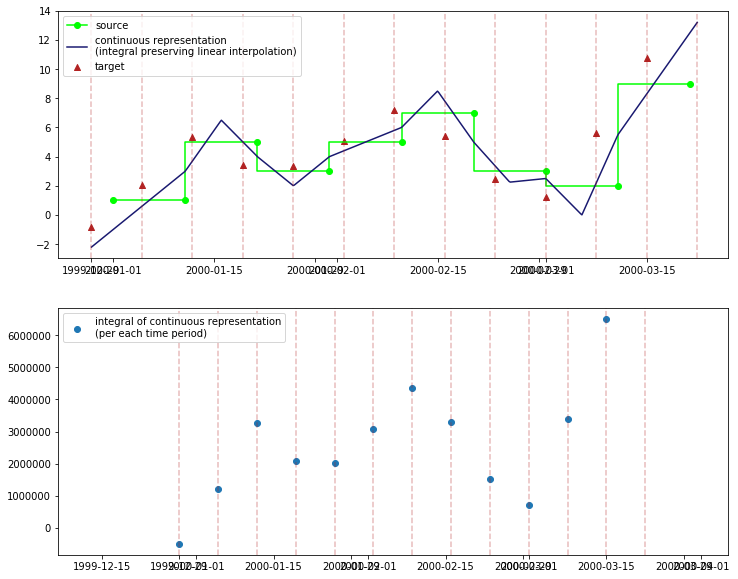

In [24]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(211)
plot_timeframe(
    ax,
    source_times,
    source_values,
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    target_times[0].astype(float),
    target_times[-1].astype(float),
    500,
    dtype="datetime64[s]",
)
ax.plot(
    plt_times,
    continuous(plt_times),
    label="continuous representation\n(integral preserving linear interpolation)",
    marker=None,
    color=COLOUR_2,
)
ax.scatter(
    target_times[:-1],
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_2,
    label="target",
)
for x in target_times[:-1]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.axvline(x=x + target_period_length, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();


ax = fig.add_subplot(212)
ax.scatter(
    target_times[:-1],
    integrals,
    label="integral of continuous representation\n(per each time period)",
)
for x in target_times[:-1]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.axvline(x=x + target_period_length, color=COLOUR_3, alpha=0.3, ls="--")
ax.legend();

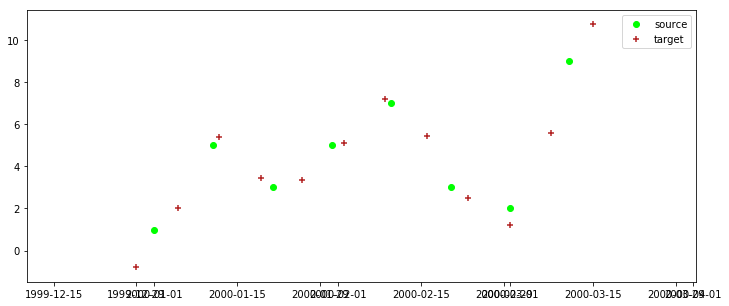

In [25]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times[:-1],
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source",
)
ax.scatter(
    target_times[:-1],
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_3,
    label="target",
)
ax.legend();

### Using OpenSCM

Requesting the data from this view includes an automatic conversion onto our new timeseries.

In [26]:
target_view.values

timeseries(array([-0.8       ,  2.02142857,  5.37857143,  3.42857143,  3.34285714,
        5.1       ,  7.18571429,  5.44642857,  2.49642857,  1.20714286,
        5.59285714, 10.75      ]))

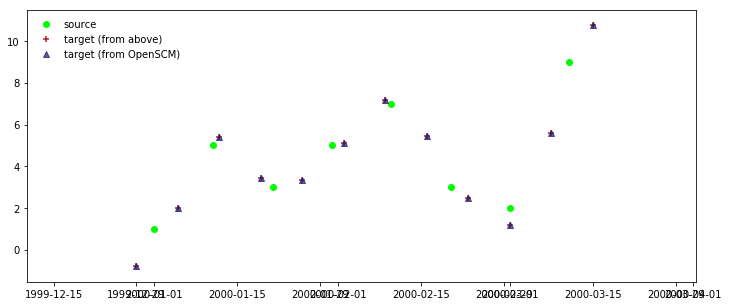

In [27]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.scatter(
    source_times[:-1],
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source",
)
ax.scatter(
    target_times[:-1],
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_3,
    label="target (from above)",
)
ax.scatter(
    target_times[:-1],
    target_view.values,
    marker=MARKER_2,
    color=COLOUR_2,
    alpha=0.7,
    label="target (from OpenSCM)",
)
ax.legend(frameon=False);

This result may seem non-intuitive at a first glance, but is due to the preservation of the integrals and, thus, different to a more intuitive linear interpolation.